

# Opcion 3  - dataset de diabetes

El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos y predecir que pacientes van a volver a ser ingresados. No me interesa ver si es <30 o >30 el tiempo de reingreso por lo que ambas categorias van a convertirse en un 1 de la variable target

Los datos son de https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#

In [213]:
%matplotlib inline

import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, make_scorer
from sklearn.model_selection  import GridSearchCV, ParameterGrid
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


C:\Users\ax-94\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [214]:
input_data_path = 'diabetes_datasets/'

In [215]:
diabetes = pd.read_csv(input_data_path + 'diabetic_data.csv', sep=',')
admission_source = pd.read_csv(input_data_path + 'admission_source_id.csv', sep=',')
admission_type = pd.read_csv(input_data_path + 'admission_type_id.csv', sep=',')
discharge_disposition = pd.read_csv(input_data_path + 'discharge_disposition_id.csv')



### Veo que esten bien cargados los datos

Para cada una de las bases cargadas observo cuál es el tamaño de las mismas y los primeros registros. Además, miro las variables, sus formatos y si tienen nulos.

In [216]:
# Tamaño de la base
diabetes.shape

(101766, 50)

In [217]:
# Miro los primeros registros
diabetes.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [218]:
# Miro las variables
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [219]:
# Tamaño de la base
admission_source.shape

(25, 2)

In [220]:
# Miro los primeros registros
admission_source.head()

,admission_source_id,description
0,1,Physician Referral
1,2,Clinic Referral
2,3,HMO Referral
3,4,Transfer from a hospital
4,5,Transfer from a Skilled Nursing Facility (SNF)


In [221]:
# Tamaño de la base
admission_type.shape

(8, 2)

In [222]:
# Miro los primeros registros
admission_type.head()

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


In [223]:
# Tamaño de la base
discharge_disposition.shape

(30, 2)

In [224]:
# Miro los primeros registros
discharge_disposition.head()

,discharge_disposition_id,description
0,1,Discharged to home
1,2,Discharged/transferred to another short term hospital
2,3,Discharged/transferred to SNF
3,4,Discharged/transferred to ICF
4,5,Discharged/transferred to another type of inpatient care institution


La base diabetes tiene la información importante, las otros 3 bases cargadas son descripciones de variables del DataFrame.



### Junto todos los datos en el mismo DataFrame

In [225]:
# Hago el join del DataFrame con las descripciones de las variables 
df=diabetes.merge(admission_source, on=['admission_source_id'], how='left').merge(admission_type, on=['admission_type_id'], how='left').merge(discharge_disposition, on=['discharge_disposition_id'], how='left')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description_x,description_y,description
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,NO,Physician Referral,NaN,Not Mapped
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,No,No,No,Ch,Yes,>30,Emergency Room,Emergency,Discharged to home
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,Yes,NO,Emergency Room,Emergency,Discharged to home
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home




### estudiar las dimensiones del dataset

In [226]:
# Miro la base original
diabetes.shape

(101766, 50)

In [227]:
# Miro la base nueva con las 3 nuevas variables
df.shape

(101766, 53)

In [228]:
# Miro las columnas del DataFrame nuevo
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'description_x', 'description_y', 'description'],
      dtype='object')



## Data Wrangling



### cambio los nombres de las columnas para que cumplan buenas prácticas

Cambio los nombres de las variables agregadas en el merge anterior para que queden como corresponden. Además, cambio guiones medios por bajos y mayúsuculas por minúsculas en los nombres de las variables.

In [229]:
# Renombro variables y miro como queda el DataFrame
df.rename(columns={'description_x': 'admission_source','description_y':'admission_type','description':'discharge_disposition',
                   'A1Cresult' : 'a1cresult', 'glyburide-metformin' : 'glyburide_metformin', 
                   'glipizide-metformin' : 'glipizide_metformin','glimepiride-pioglitazone' : 'glimepiride_pioglitazone', 
                   'metformin-rosiglitazone' : 'metformin_rosiglitazone','metformin-pioglitazone' : 'metformin_pioglitazone', 
                   'diabetesMed' : 'diabetesmed'}, inplace=True)
print(df.columns)

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'a1cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide_metformin', 'glipizide_metformin',
       'glimepiride_pioglitazone', 'metformin_rosiglitazone',
       'metformin_pioglitazone', 'change', 'diabetesmed', 'readmitted',
       'admission_source', 'admission_type', 'discharge_disposition'],
      dtype='object')



### estudio el formato de las variables

In [230]:
# Miro los tipos de variables que tengo
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

Observando el tipo de datos de las variables se puede identificar que los id tienen formato numérico, esto no es lo mejor a la hora de realizar análisis por eso cambio el tipo de datos a string

In [231]:
df['encounter_id'] = df['encounter_id'].astype('str')
df['patient_nbr'] = df['patient_nbr'].astype('str')
df['admission_type_id'] = df['admission_type_id'].astype('str')
df['discharge_disposition_id'] = df['discharge_disposition_id'].astype('str')
df['admission_source_id'] = df['admission_source_id'].astype('str')

Genero la variable "target" a partir de la variable "readmitted", que toma el valor 0 si la categoría es 'NO' y el valor 1 en cualquiera de los otros casos. El problema que voy a estudiar es si la persona va a ser readmitida o no

In [232]:
df['target'] = df['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 54 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  object
 1   patient_nbr               101766 non-null  object
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  object
 7   discharge_disposition_id  101766 non-null  object
 8   admission_source_id       101766 non-null  object
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [234]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,readmitted,admission_source,admission_type,discharge_disposition,target
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,NO,Physician Referral,NaN,Not Mapped,0
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,No,No,Ch,Yes,>30,Emergency Room,Emergency,Discharged to home,1
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,Yes,NO,Emergency Room,Emergency,Discharged to home,0
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home,0
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home,0




### estudio si hay registros repetidos

In [235]:
df.duplicated().any()

False

No existen registros repetidos en el DataFrame.



### estudio si hay variables que siempre o prácticamente siempre toman el mismo valor: tomar siempre el mismo valor no aporta información al modelo

In [236]:
# Armo un DF con las variables categóricas
df_cat = df.select_dtypes(include = ['object'])

In [237]:
# Miro cuántas categorías tiene cada variable
df_cat.nunique()

encounter_id                101766
patient_nbr                 71518 
race                        6     
gender                      3     
age                         10    
weight                      10    
admission_type_id           8     
discharge_disposition_id    26    
admission_source_id         17    
payer_code                  18    
medical_specialty           73    
diag_1                      717   
diag_2                      749   
diag_3                      790   
max_glu_serum               4     
a1cresult                   4     
metformin                   4     
repaglinide                 4     
nateglinide                 4     
chlorpropamide              4     
glimepiride                 4     
acetohexamide               2     
glipizide                   4     
glyburide                   4     
tolbutamide                 2     
pioglitazone                4     
rosiglitazone               4     
acarbose                    4     
miglitol            

Se puede ver que las variables encounter_id, patient_nbr son identificadores de registros.

Las variables examide y citoglipton toman un único valor, por lo que son eliminadas de la base a analizar.

Por otro lado, las variables diag_1, diag_2, diag_3 toman un gran número de categorías y como no tengo una descripción de las mismas también las elimino en el análisis de variables categóricas.

Además, las descripciones agregadas y sus id son variables idénticas, por lo que sería correcto dejar sólo una de ellas.

In [238]:
# Elimino las variables mencionadas arriba para realizar el análisis
var_elim=['encounter_id', 'patient_nbr', 'examide', 'citoglipton', 'diag_1', 'diag_2', 'diag_3','admission_type_id',
          'discharge_disposition_id','admission_source_id']
df_cat = df_cat.drop(var_elim, axis=1)

C:\Users\ax-94\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


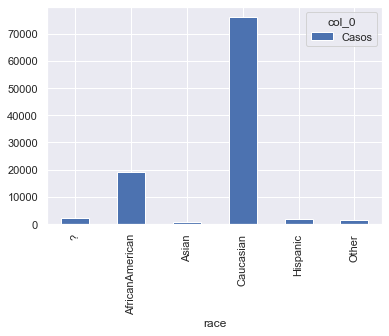

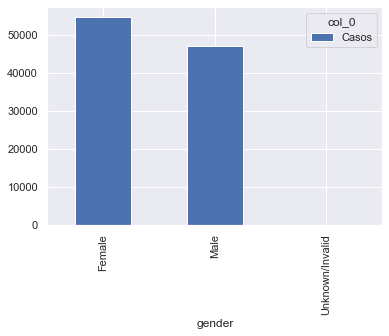

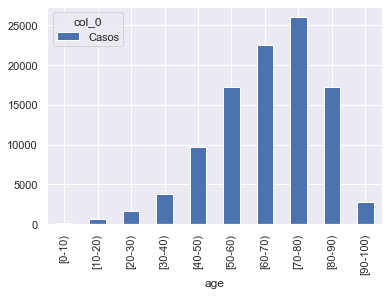

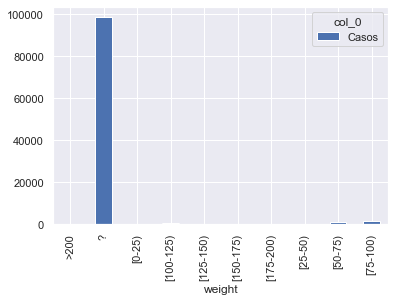

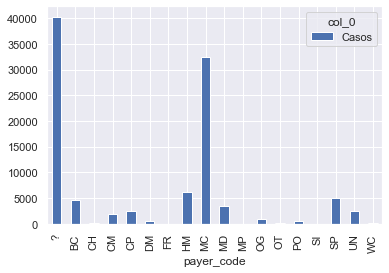

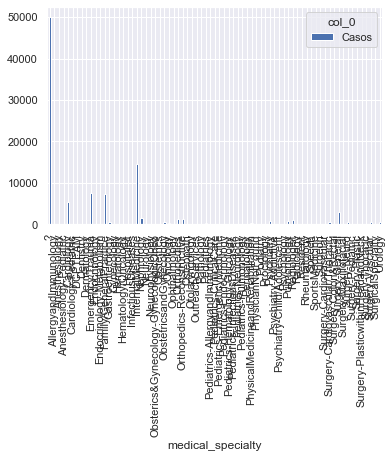

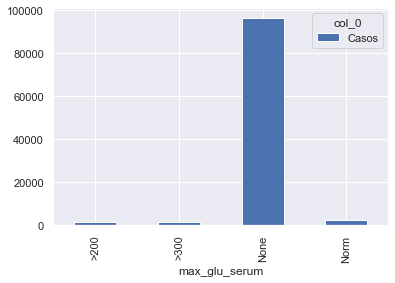

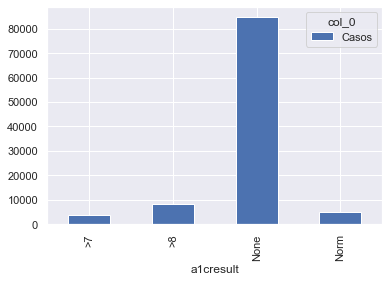

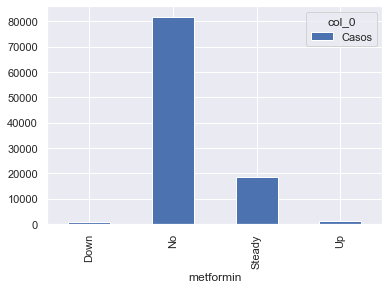

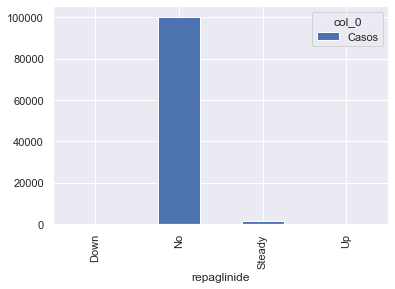

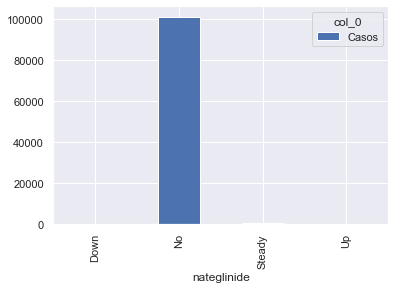

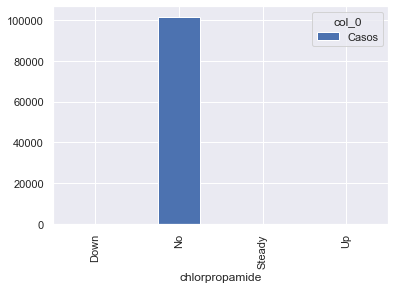

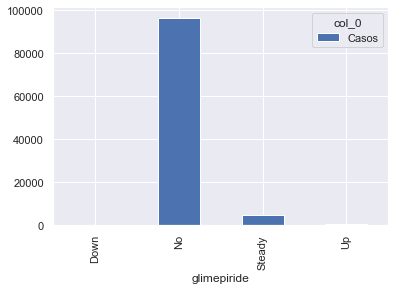

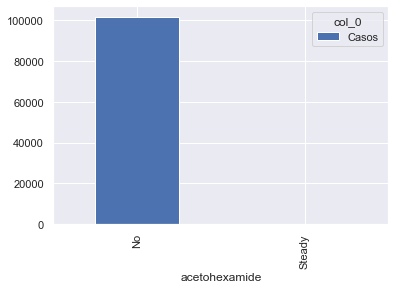

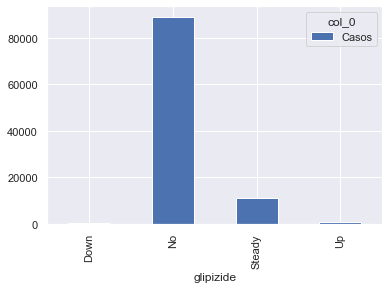

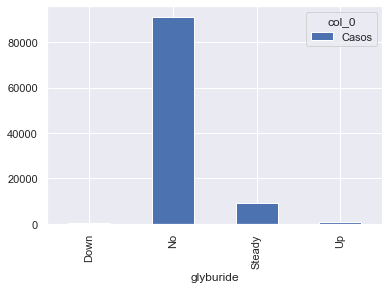

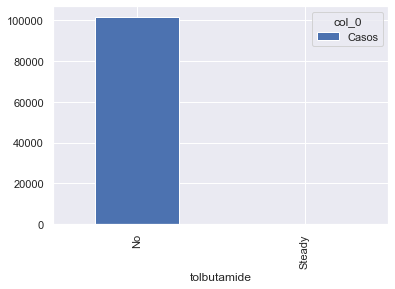

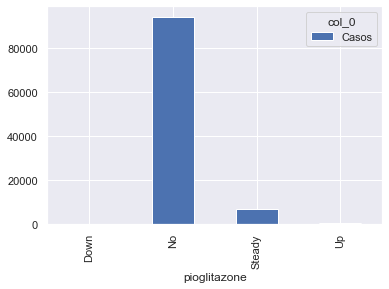

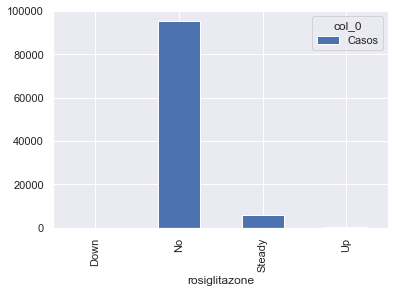

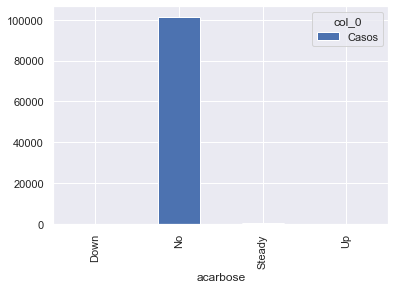

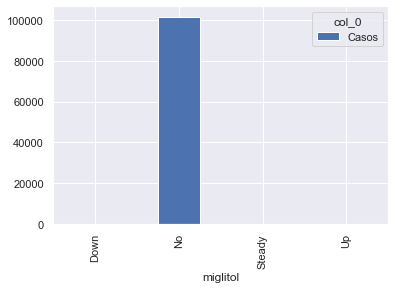

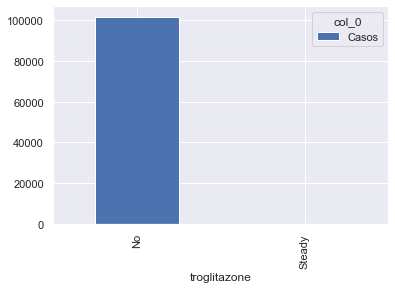

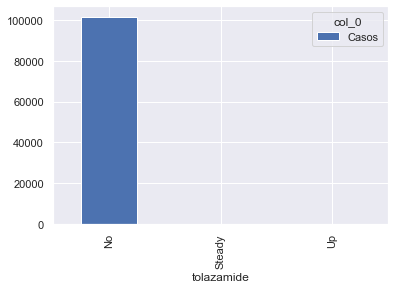

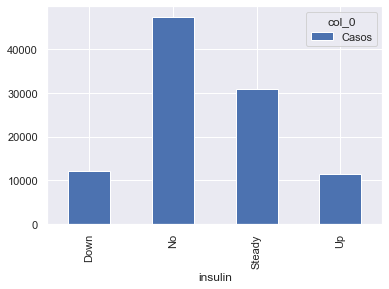

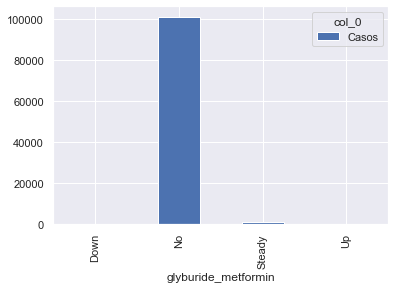

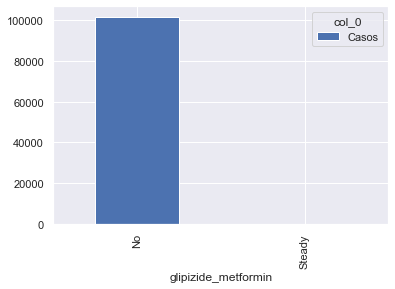

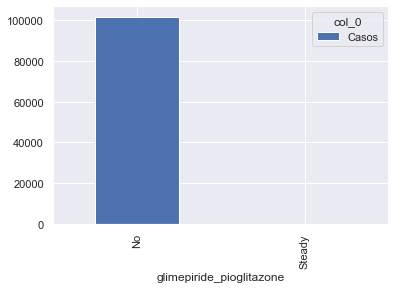

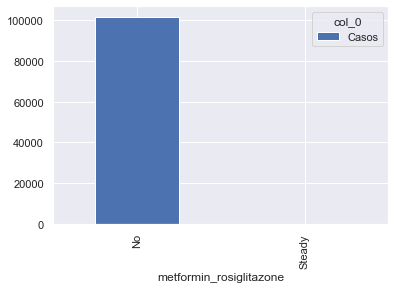

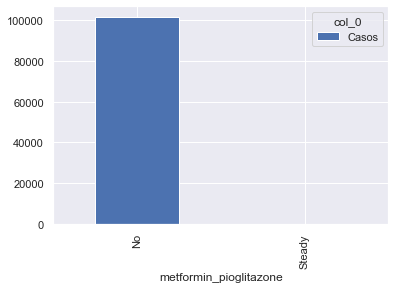

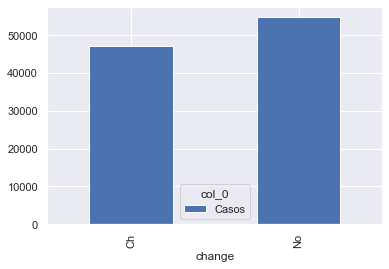

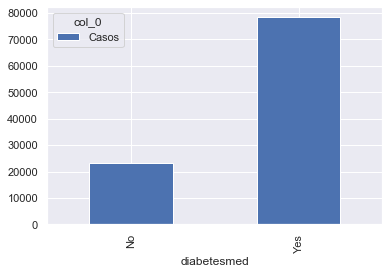

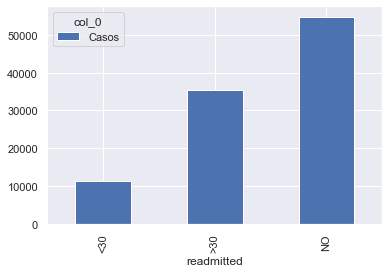

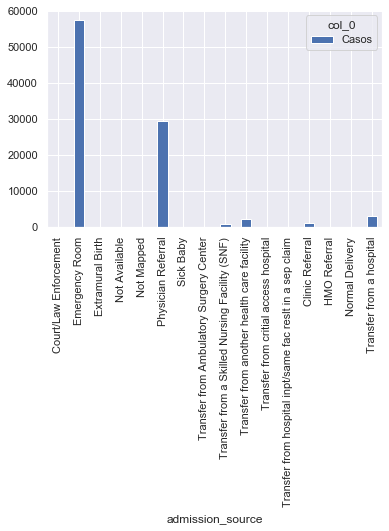

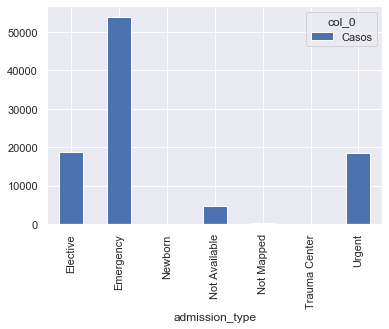

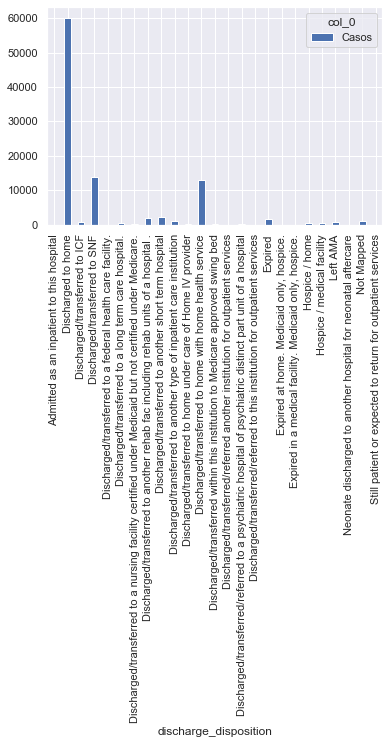

In [239]:
# Armo un count por categoría
for x in df_cat.columns:
    pd.crosstab(index = df_cat[x],columns="Casos").plot.bar()

Las variables race, gender, payer_code y medical_specialty si bien siempre toman algún valor y la herramienta no detecta valores nulos hay algunos que aparecen con "?" o valores extraños. En estos casos es recomendable analizar los bivariados de estas variables y ver qué valor se le imputa a cada una.

Por otro lado, las variables age, admission_type, discharge_disposition, admission_source, payer_code y medical_specialty tienen muchas categorías posibles, por lo que también es recomendable analizar los bivariados y entender si no se pueden simplificar.

Las variables weight, max_glu_serum, repaglinide, nateglidine, chlorpropamide, glimepiride, acetohexamide, tolbutamide, acarbose, miglitol, troglitazone, tolazamide, glyburide_metformin, glipizide_metmorfin, glimepiride_pioglitazone, metmorfin_rosiglitazone y metmorfin_pioglitazone la mayor parte de las observaciones toman un único valor por lo que sería recomendable eliminarlas. A lo sumo, se podría analizar crear la variable "uso de alguna droga" y ver si tiene sentido analítico.



### estudiar los nulos en el dataset

In [240]:
df.isnull().values.any()

True

In [241]:
for col in ['admission_source', 'admission_type', 'discharge_disposition']:
    print('Cantidad de nulos:', col, df[col].isnull().sum(), '\n')
    print('Valores frecuentes: \n', df[col].value_counts(), '\n')

Cantidad de nulos: admission_source 6781 

Valores frecuentes: 
  Emergency Room                                               57494
 Physician Referral                                           29565
Transfer from a hospital                                      3187 
 Transfer from another health care facility                   2264 
Clinic Referral                                               1104 
 Transfer from a Skilled Nursing Facility (SNF)               855  
HMO Referral                                                  187  
 Not Mapped                                                   161  
 Not Available                                                125  
 Court/Law Enforcement                                        16   
 Transfer from hospital inpt/same fac reslt in a sep claim    12   
 Transfer from critial access hospital                        8    
 Extramural Birth                                             2    
Normal Delivery                                    

La moda de estas variables es bastante preponderante, asi que voy a llenar los null con la misma

In [242]:
for col in ['admission_source', 'admission_type', 'discharge_disposition']:
    df[col] = df[col].fillna(df[col].value_counts().index[0])

Ademas, ya vimos en el apartado anterior hay información que no está completa con un dato real

In [243]:
#Miro las variables que toman valores raros
np.sum(df=='?',axis=0)

C:\Users\ax-94\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


encounter_id                0    
patient_nbr                 0    
race                        2273 
gender                      0    
age                         0    
weight                      98569
admission_type_id           0    
discharge_disposition_id    0    
admission_source_id         0    
time_in_hospital            0    
payer_code                  40256
medical_specialty           49949
num_lab_procedures          0    
num_procedures              0    
num_medications             0    
number_outpatient           0    
number_emergency            0    
number_inpatient            0    
diag_1                      21   
diag_2                      358  
diag_3                      1423 
number_diagnoses            0    
max_glu_serum               0    
a1cresult                   0    
metformin                   0    
repaglinide                 0    
nateglinide                 0    
chlorpropamide              0    
glimepiride                 0    
acetohexamide 

                 target_sum  target_count  proporcion_target
race                                                        
?                726         2273          0.319402         
AfricanAmerican  8789        19210         0.457522         
Asian            226         641           0.352574         
Caucasian        35716       76099         0.469336         
Hispanic         854         2037          0.419244         
Other            591         1506          0.392430         


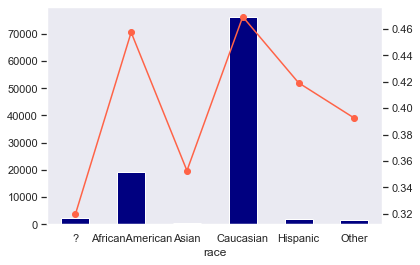

In [244]:
#Armo el bivariado de "race"
grouped = df.groupby('race').agg({'target':['sum','count']})
grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
grouped["proporcion_target"]=grouped["target_sum"]/grouped["target_count"].astype(float)
print(grouped)
grouped[['target_count']].plot(kind='bar',color='navy',legend=None)
grouped['proporcion_target'].plot(secondary_y=True, linestyle='-', marker='o',lw=1.5,color='tomato').grid(b=None)

La categoría "?" tiene una relación bastante diferente al resto con la variable target por lo que no sería correcto agruparla, por lo tanto voy a cambiar la categoría a "No Informado".

            target_sum  target_count  proporcion_target
payer_code                                             
?           18455       40256         0.458441         
BC          1727        4655          0.370999         
CH          46          146           0.315068         
CM          859         1937          0.443469         
CP          995         2533          0.392815         
DM          284         549           0.517304         
FR          0           1             0.000000         
HM          2964        6274          0.472426         
MC          15792       32439         0.486821         
MD          1675        3532          0.474236         
MP          48          79            0.607595         
OG          469         1033          0.454017         
OT          45          95            0.473684         
PO          188         592           0.317568         
SI          24          55            0.436364         
SP          2379        5007          0.475135  

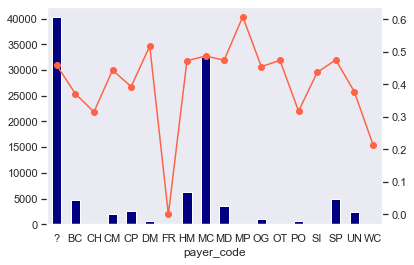

In [245]:
#Armo el bivariado de "payer_code"
grouped = df.groupby("payer_code").agg({"target":['sum','count']})
# Using ravel, and a string join, we can create better names for the columns:
grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
grouped["proporcion_target"]=grouped["target_sum"]/grouped["target_count"].astype(float)
print(grouped)
grouped[['target_count']].plot(kind='bar',color='navy',legend=None)
grouped['proporcion_target'].plot(secondary_y=True, linestyle='-', marker='o',lw=1.5,color='tomato').grid(b=None)

Nuevamente, el signo "?" es para identificar a los no informados por lo que le voy a cambiar el valor de la categoría

                                  target_sum  target_count  proporcion_target
medical_specialty                                                            
?                                 23997       49949         0.480430         
AllergyandImmunology              6           7             0.857143         
Anesthesiology                    4           12            0.333333         
Anesthesiology-Pediatric          6           19            0.315789         
Cardiology                        2278        5352          0.425635         
...                              ..           ..                 ...         
Surgery-PlasticwithinHeadandNeck  1           1             1.000000         
Surgery-Thoracic                  41          109           0.376147         
Surgery-Vascular                  274         533           0.514071         
SurgicalSpecialty                 11          33            0.333333         
Urology                           253         685           0.36

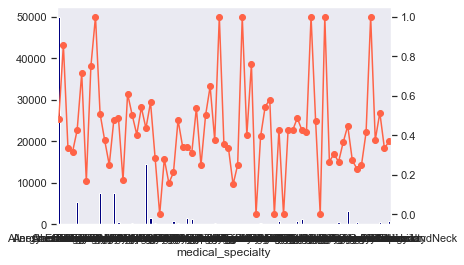

In [246]:
#Armo el bivariado de "medical_specialty"
grouped = df.groupby("medical_specialty").agg({"target":['sum','count']})
grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
grouped["proporcion_target"]=grouped["target_sum"]/grouped["target_count"].astype(float)
print(grouped)
grouped[['target_count']].plot(kind='bar',color='navy',legend=None)
grouped['proporcion_target'].plot(secondary_y=True, linestyle='-', marker='o',lw=1.5,color='tomato').grid(b=None)

La variable medical_specialty toma muchas categorías y los datos están muy distribuidos, ademas que la categoría con más repeticiones es "?", por lo que elimino la variable

                 target_sum  target_count  proporcion_target
gender                                                      
Female           25670       54708         0.469218         
Male             21232       47055         0.451217         
Unknown/Invalid  0           3             0.000000         


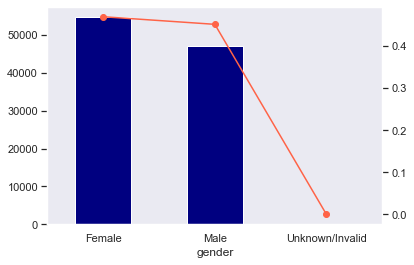

In [247]:
#Armo el bivariado de "gender"
grouped = df.groupby("gender").agg({"target":['sum','count']})
grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
grouped["proporcion_target"]=grouped["target_sum"]/grouped["target_count"].astype(float)
print(grouped)
grouped[['target_count']].plot(kind='bar',color='navy',legend=None)
grouped['proporcion_target'].plot(secondary_y=True, linestyle='-', marker='o',lw=1.5,color='tomato').grid(b=None)

A los valores "Unknown" de la variable les imputo el valor "Female" por que son sólo 3 observaciones.

In [248]:
#Hago los reemplazos de "?"
df['race'] = df['race'].str.replace('?','NO INFORMADO')
df['payer_code'] = df['payer_code'].str.replace('?','NA')
df['gender'] = df['gender'].str.replace('Unknown/Invalid','Female')

In [249]:
df['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
NO INFORMADO       2273 
Hispanic           2037 
Other              1506 
Asian              641  
Name: race, dtype: int64

In [250]:
df['payer_code'].value_counts()

NA    40256
MC    32439
HM    6274 
SP    5007 
BC    4655 
MD    3532 
CP    2533 
UN    2448 
CM    1937 
OG    1033 
PO    592  
DM    549  
CH    146  
WC    135  
OT    95   
MP    79   
SI    55   
FR    1    
Name: payer_code, dtype: int64

In [251]:
df['gender'].value_counts()

Female    54711
Male      47055
Name: gender, dtype: int64

In [252]:
df.dtypes

encounter_id                object
patient_nbr                 object
race                        object
gender                      object
age                         object
weight                      object
admission_type_id           object
discharge_disposition_id    object
admission_source_id         object
time_in_hospital            int64 
payer_code                  object
medical_specialty           object
num_lab_procedures          int64 
num_procedures              int64 
num_medications             int64 
number_outpatient           int64 
number_emergency            int64 
number_inpatient            int64 
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses            int64 
max_glu_serum               object
a1cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         



### estudiar los outliers

In [253]:
# Dejo en un DataFrame las variables continuas
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,target
0,1,41,0,1,0,0,0,1,0
1,3,59,0,18,0,0,0,9,1
2,2,11,5,13,2,0,1,6,0
3,2,44,1,16,0,0,0,7,0
4,1,51,0,8,0,0,0,5,0


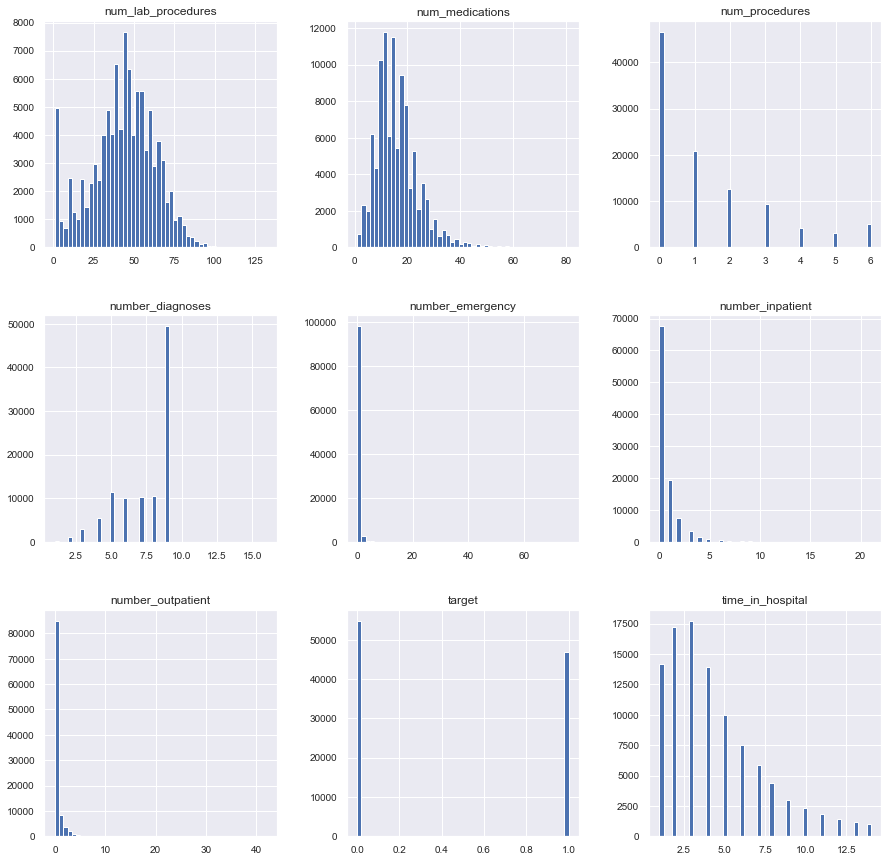

In [254]:
# Miro los histogramas de las variables continuas y analizo si existen outliers
df_num.hist(figsize=(15, 15), bins=50, xlabelsize=10, ylabelsize=10);

In [255]:
df_num.describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99])

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,target
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607,0.460881
std,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600,0.498470
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1%,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,2.000000,0.000000
5%,1.000000,4.000000,0.000000,6.000000,0.000000,0.000000,0.000000,4.000000,0.000000
10%,1.000000,14.000000,0.000000,7.000000,0.000000,0.000000,0.000000,5.000000,0.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,0.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,1.000000


Las variables: num_lab_procedures, num_medications, number_diagnosis, number_emergency, number_outpatient, tienen valores outliers.
En estos casos, lo que se podría hacer es truncar las variables con el valor del percentil 99 de distribución.

In [256]:
# Topeo en el percentil 99 las variables observadas con outliers
df['num_lab_procedures'] = df['num_lab_procedures'].apply(lambda x: 85 if x > 85 else x)
df['num_medications'] = df['num_medications'].apply(lambda x: 43 if x > 43 else x)
df['number_diagnoses'] = df['number_diagnoses'].apply(lambda x: 9 if x > 9 else x)
df['number_emergency'] = df['number_emergency'].apply(lambda x: 3 if x > 3 else x)
df['number_outpatient'] = df['number_outpatient'].apply(lambda x: 5 if x > 5 else x)

In [257]:
df.describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99])

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,target
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,4.395987,43.036810,1.339730,15.943685,0.329599,0.164623,0.635566,7.417300,0.460881
std,2.985108,19.530666,1.705807,7.796711,0.909908,0.525132,1.262863,1.921251,0.498470
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1%,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,2.000000,0.000000
5%,1.000000,4.000000,0.000000,6.000000,0.000000,0.000000,0.000000,4.000000,0.000000
10%,1.000000,14.000000,0.000000,7.000000,0.000000,0.000000,0.000000,5.000000,0.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,0.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,1.000000




### creo variables dummy 

In [258]:
# Genero un nuevo DataFrame a partir de df eliminando las variables analizadas anteriormente y que considero que no aportan información
# Elimino las variables mencionadas arriba para realizar el análisis
var_elim=['encounter_id', 'patient_nbr', 'examide', 'citoglipton', 'diag_1', 'diag_2', 'diag_3','admission_type',
          'discharge_disposition','admission_source','weight','max_glu_serum', 'repaglinide', 'nateglinide',
          'chlorpropamide', 'glimepiride','acetohexamide', 'tolbutamide', 'acarbose', 'miglitol', 'troglitazone',
          'tolazamide', 'glyburide_metformin','glipizide_metformin','glimepiride_pioglitazone','metformin_rosiglitazone',
          'metformin_pioglitazone','medical_specialty','readmitted']
df_limpio = df.drop(var_elim, axis=1)

In [259]:
df_limpio.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'a1cresult', 'metformin', 'glipizide', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'insulin', 'change', 'diabetesmed',
       'target'],
      dtype='object')

In [260]:
#Convierto en dummies la variable categórica
dfDummies = pd.get_dummies(df_limpio, columns=['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 
       'payer_code', 'a1cresult', 'metformin', 'glipizide', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'insulin', 'change', 'diabetesmed',])

In [261]:
dfDummies.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,target,race_AfricanAmerican,...,rosiglitazone_Steady,rosiglitazone_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesmed_No,diabetesmed_Yes
0,1,41,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,1,0
1,3,59,0,18,0,0,0,9,1,0,...,0,0,0,0,0,1,1,0,0,1
2,2,11,5,13,2,0,1,6,0,1,...,0,0,0,1,0,0,0,1,0,1
3,2,44,1,16,0,0,0,7,0,0,...,0,0,0,0,0,1,1,0,0,1
4,1,51,0,8,0,0,0,5,0,0,...,0,0,0,0,1,0,1,0,0,1


In [262]:
#Le saco todos los caracteres especiales y mayusculas a los nombres de las columnas
dfDummies.columns = [name.lower().replace('-','_') for name in dfDummies.columns]
dfDummies.columns = [name.lower().replace('.','_') for name in dfDummies.columns]
dfDummies.columns = [name.lower().replace(' ','_') for name in dfDummies.columns]
dfDummies.columns = [name.lower().replace('/','_') for name in dfDummies.columns]
dfDummies.columns = [name.lower().replace('__','_') for name in dfDummies.columns]
dfDummies.columns = [name.lower().replace(' ','') for name in dfDummies.columns]

In [263]:
# Las miro
dfDummies.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'target',
       'race_africanamerican',
       ...
       'rosiglitazone_steady', 'rosiglitazone_up', 'insulin_down',
       'insulin_no', 'insulin_steady', 'insulin_up', 'change_ch', 'change_no',
       'diabetesmed_no', 'diabetesmed_yes'],
      dtype='object', length=128)



# Analisis exploratorio



### Estudio correlación

In [264]:
#Miro la correlación entre las variables numéricas
df_num = dfDummies.select_dtypes(include = ['int64'])
corr= df_num.corr()
corr

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,target
time_in_hospital,1.000000,0.316731,0.191472,0.470718,-0.015098,-0.006883,0.073623,0.220702,0.051289
num_lab_procedures,0.316731,1.000000,0.056102,0.267751,-0.016483,0.002485,0.039706,0.152464,0.039889
num_procedures,0.191472,0.056102,1.000000,0.380457,-0.032131,-0.050248,-0.066236,0.073477,-0.044748
num_medications,0.470718,0.267751,0.380457,1.000000,0.054236,0.027448,0.069379,0.269029,0.051214
number_outpatient,-0.015098,-0.016483,-0.032131,0.054236,1.000000,0.156116,0.128162,0.106109,0.095070
number_emergency,-0.006883,0.002485,-0.050248,0.027448,0.156116,1.000000,0.295008,0.081151,0.131085
number_inpatient,0.073623,0.039706,-0.066236,0.069379,0.128162,0.295008,1.000000,0.105012,0.217194
number_diagnoses,0.220702,0.152464,0.073477,0.269029,0.106109,0.081151,0.105012,1.000000,0.113297
target,0.051289,0.039889,-0.044748,0.051214,0.095070,0.131085,0.217194,0.113297,1.000000


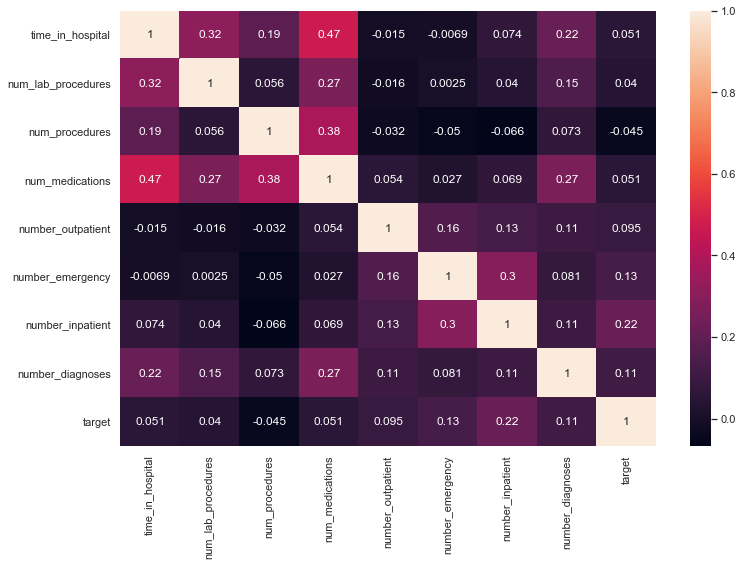

In [265]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr, 
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values,
            annot = True);



### veo que par de variables están correlacionadas

In [266]:
#Considero correlación alta a la que supera 0.4
corr1=corr[corr>0.4]
corr1

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,target
time_in_hospital,1.000000,NaN,NaN,0.470718,NaN,NaN,NaN,NaN,NaN
num_lab_procedures,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_procedures,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
num_medications,0.470718,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
number_outpatient,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
number_emergency,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
number_inpatient,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
number_diagnoses,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
target,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0




### estudio los pares de variables correlacionadas para quedarme solamente con una

Las variable con mayor correlación son time_in_hospital y num_medications.

Además, las dos se correlacionan igual con la variable target.

Voy a analizar los boxplot de las mismas vs la variable target para entender si en algún lugar se ven diferencias.

(array([0, 1]), <a list of 2 Text xticklabel objects>)

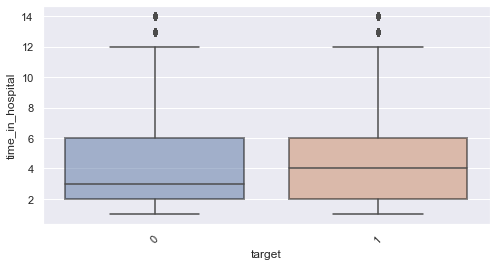

In [267]:
# Armo box-plot para las variables time_in_hospital vs target
plt.figure(figsize = (8, 4))
ax = sns.boxplot(x='target', y='time_in_hospital', data=dfDummies)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

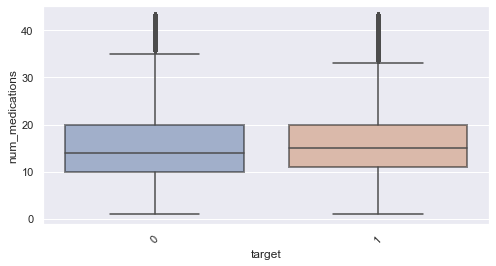

In [268]:
# Armo box-plot para las variables num_medications vs target
plt.figure(figsize = (8, 4))
ax = sns.boxplot(x='target', y='num_medications', data=dfDummies)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

A partir del box-plot veo que la variable time_in_hospital porque la distribución varía más entre los distintos niveles de target (igualmente se podría probar modelos incluyendo a una u otra variable).

In [269]:
#Descarto num_medications
dfDummies.drop(['num_medications'], axis=1, inplace=True)



# Modelado



### seleccionacion de variables

##### Antes de utilizar un método de selección de variables automático, voy a analizar la relación de cada una de las variables en el DataFrame con la variable target

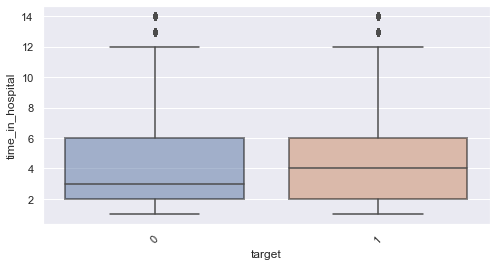

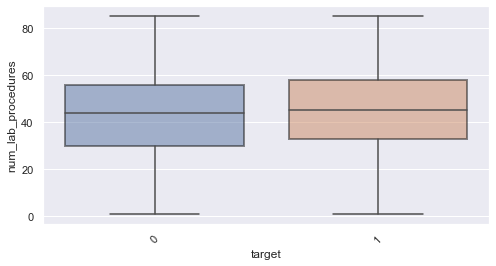

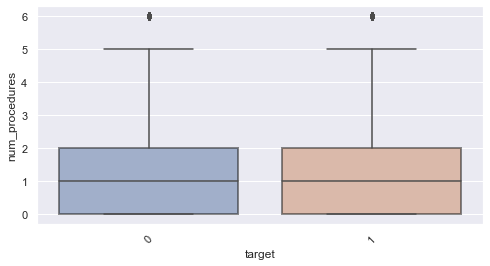

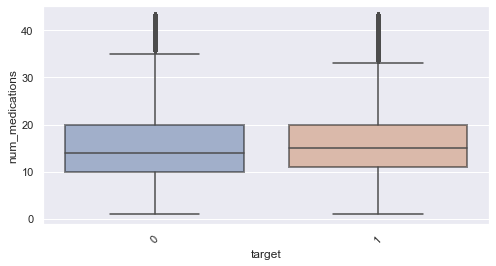

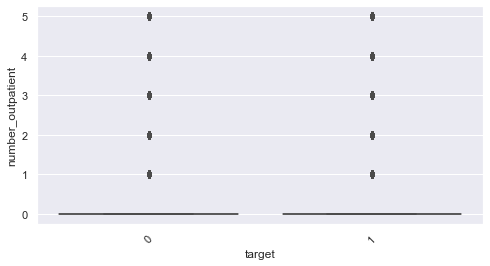

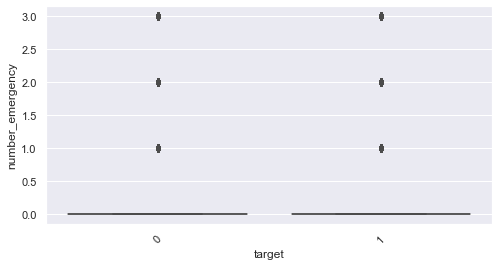

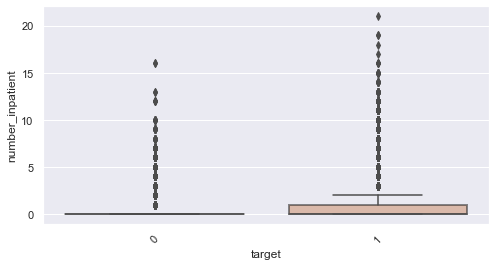

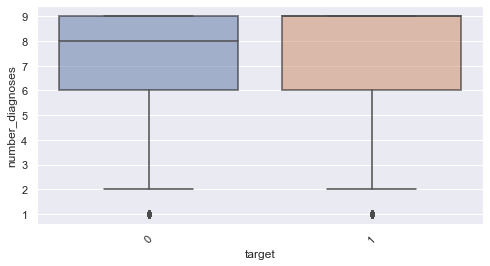

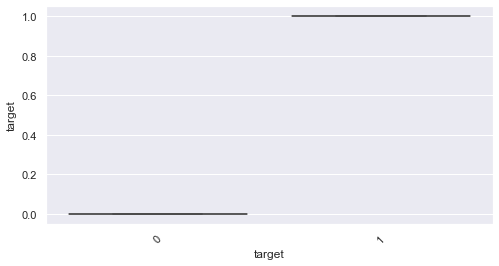

In [270]:
# Box-Plot para variables continuas

for x in df_num.columns:
   #pd.crosstab(index = df_cat[x],columns="Casos").plot.bar()
    plt.figure(figsize = (8, 4))
    ax = sns.boxplot(x='target', y=df_num[x], data=dfDummies)
    plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
    plt.xticks(rotation=45)

De los gráficos anteriores se puede observar que las variables que tienen comportamiento un poco diferente entre los distintos niveles de variable target son time_in hospital, num_lab_procedures, number_inpatient y number_of_diagnoses.

#### Ahora miro la relación entre las variables categóricas y la variable target a traves de un bivariante

In [271]:
# Vuelvo a armar el DataFrame de variables categóricas. Esta vez lo tomo del df_limpio porque en dfDummies ya están las variables flag numéricas
df_cat = df_limpio.select_dtypes(include = ['object'])
df_cat.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'payer_code',
       'a1cresult', 'metformin', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesmed'],
      dtype='object')

                 target_sum  target_count  proporcion_target
race                                                        
AfricanAmerican  8789        19210         0.457522         
Asian            226         641           0.352574         
Caucasian        35716       76099         0.469336         
Hispanic         854         2037          0.419244         
NO INFORMADO     726         2273          0.319402         
Other            591         1506          0.392430         
        target_sum  target_count  proporcion_target
gender                                             
Female  25670       54711         0.469193         
Male    21232       47055         0.451217         
          target_sum  target_count  proporcion_target
age                                                  
[0-10)    29          161           0.180124         
[10-20)   264         691           0.382055         
[20-30)   746         1657          0.450211         
[30-40)   1611        3775        

        target_sum  target_count  proporcion_target
change                                             
Ch      22830       47011         0.485631         
No      24072       54755         0.439631         
             target_sum  target_count  proporcion_target
diabetesmed                                             
No           9473        23403         0.404777         
Yes          37429       78363         0.477636         


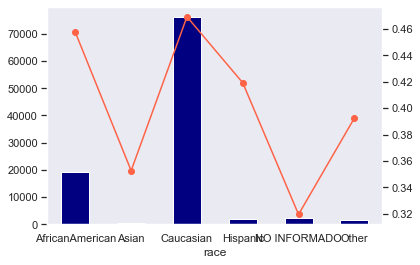

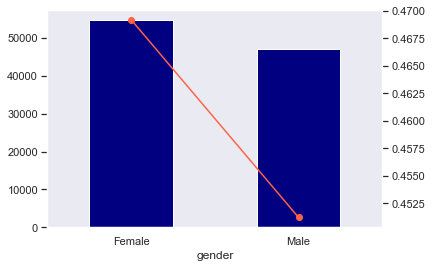

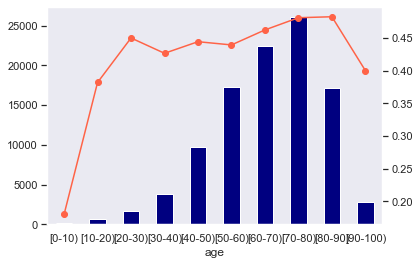

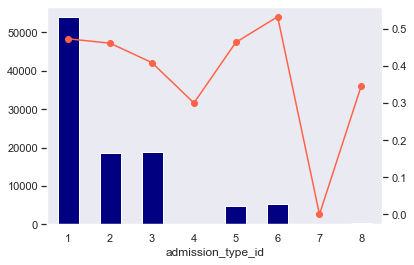

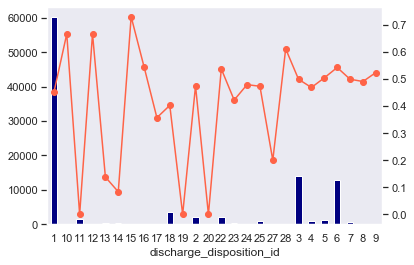

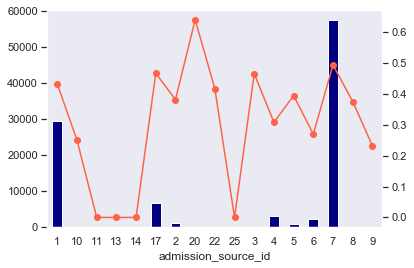

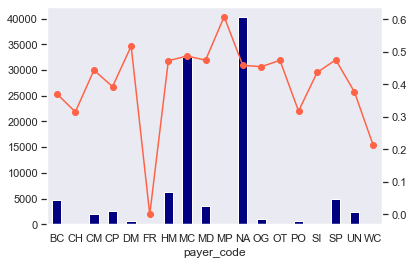

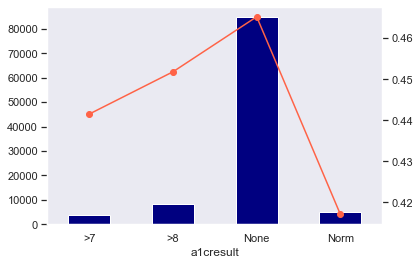

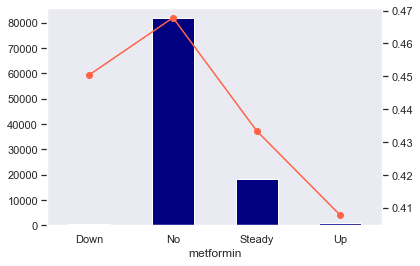

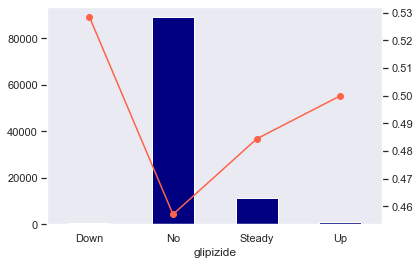

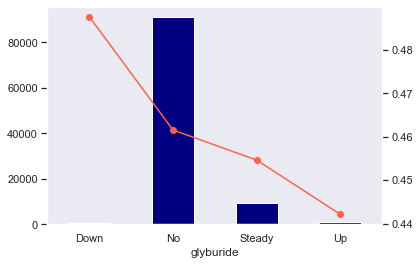

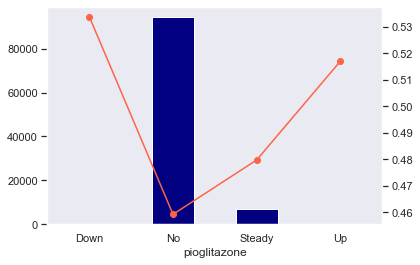

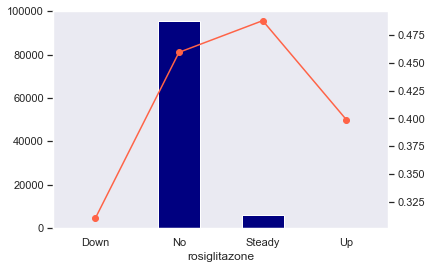

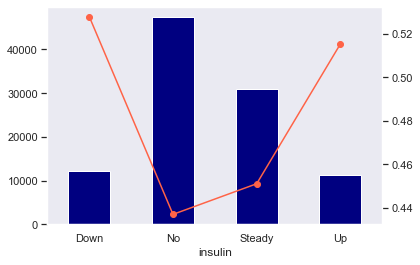

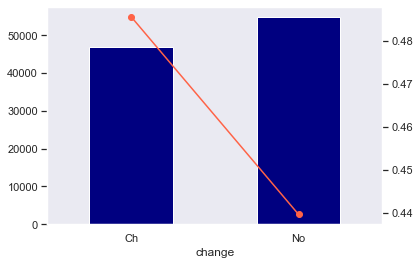

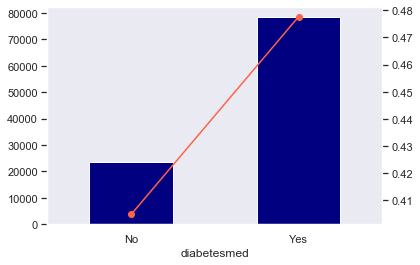

In [272]:
for x in df_cat.columns:
    grouped = df.groupby(df_cat[x]).agg({"target":['sum','count']})
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    grouped["proporcion_target"]=grouped["target_sum"]/grouped["target_count"].astype(float)
    print(grouped)
    grouped[['target_count']].plot(kind='bar',color='navy',legend=None)
    grouped['proporcion_target'].plot(secondary_y=True, linestyle='-', marker='o',lw=1.5,color='tomato').grid(b=None)

Utilizo un método automático para seleccionar las variables

In [273]:
dfDummies

,time_in_hospital,num_lab_procedures,num_procedures,number_outpatient,number_emergency,number_inpatient,number_diagnoses,target,race_africanamerican,race_asian,...,rosiglitazone_steady,rosiglitazone_up,insulin_down,insulin_no,insulin_steady,insulin_up,change_ch,change_no,diabetesmed_no,diabetesmed_yes
0,1,41,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,1,0
1,3,59,0,0,0,0,9,1,0,0,...,0,0,0,0,0,1,1,0,0,1
2,2,11,5,2,0,1,6,0,1,0,...,0,0,0,1,0,0,0,1,0,1
3,2,44,1,0,0,0,7,0,0,0,...,0,0,0,0,0,1,1,0,0,1
4,1,51,0,0,0,0,5,0,0,0,...,0,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,3,51,0,0,0,0,9,1,1,0,...,0,0,1,0,0,0,1,0,0,1
101762,5,33,3,0,0,1,9,0,1,0,...,0,0,0,0,1,0,0,1,0,1
101763,1,53,0,1,0,0,9,0,0,0,...,0,0,1,0,0,0,1,0,0,1
101764,10,45,2,0,0,1,9,0,0,0,...,0,0,0,0,0,1,1,0,0,1


In [277]:
dfDummies.columns.values

array(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'target', 'race_africanamerican', 'race_asian',
       'race_caucasian', 'race_hispanic', 'race_no_informado',
       'race_other', 'gender_female', 'gender_male', 'age_[0_10)',
       'age_[10_20)', 'age_[20_30)', 'age_[30_40)', 'age_[40_50)',
       'age_[50_60)', 'age_[60_70)', 'age_[70_80)', 'age_[80_90)',
       'age_[90_100)', 'admission_type_id_1', 'admission_type_id_2',
       'admission_type_id_3', 'admission_type_id_4',
       'admission_type_id_5', 'admission_type_id_6',
       'admission_type_id_7', 'admission_type_id_8',
       'discharge_disposition_id_1', 'discharge_disposition_id_10',
       'discharge_disposition_id_11', 'discharge_disposition_id_12',
       'discharge_disposition_id_13', 'discharge_disposition_id_14',
       'discharge_disposition_id_15', 'discharge_disposition_id_16',
       'discharge_dispo

In [274]:
# Utilizo selección de variables a través del estadístico chi-cuadrado

features, label = dfDummies.drop(['target'],axis=1), dfDummies.target
selector = SelectKBest(chi2, k=20)
features_new = selector.fit_transform(features, label)
features_new.shape

(101766, 20)

In [275]:
cols = selector.get_support(indices=True)
features_df_new = features.iloc[:,cols]
features_df_new

,time_in_hospital,num_lab_procedures,num_procedures,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_no_informado,admission_type_id_3,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_6,admission_source_id_4,admission_source_id_6,admission_source_id_7,payer_code_bc,insulin_down,insulin_up,diabetesmed_no
0,1,41,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,3,59,0,0,0,0,9,0,0,0,0,0,0,0,0,1,0,0,1,0
2,2,11,5,2,0,1,6,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2,44,1,0,0,0,7,0,0,0,0,0,0,0,0,1,0,0,1,0
4,1,51,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,3,51,0,0,0,0,9,0,0,0,0,0,0,0,0,1,0,1,0,0
101762,5,33,3,0,0,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0
101763,1,53,0,1,0,0,9,0,0,0,0,0,0,0,0,1,0,1,0,0
101764,10,45,2,0,0,1,9,0,0,0,0,0,0,0,0,1,0,0,1,0


#### Las variables elegidas fueron las siguientes:

In [278]:
features_df_new.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'race_no_informado', 'admission_type_id_3',
       'discharge_disposition_id_11', 'discharge_disposition_id_13',
       'discharge_disposition_id_14', 'discharge_disposition_id_6',
       'admission_source_id_4', 'admission_source_id_6',
       'admission_source_id_7', 'payer_code_bc', 'insulin_down', 'insulin_up',
       'diabetesmed_no'],
      dtype='object')

Por cuestiones de tiempo me quedo con una cantidad arbitraria de variables. Con mas tiempo miraria el p_valor de las mismas



### estandarizo variables

In [198]:
#Estandarizo las variables independientes
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(features_new)

In [199]:
#Separo los datasets de train y validation para las variables estandarizadas
X_std_train, X_std_test, y_std_train, y_std_test = train_test_split(X, dfDummies[['target']], test_size=0.03, random_state=42)



### corro distintos algoritmos

In [200]:
# Corro una regresión logística
classifier = LogisticRegression()
classifier.fit(X_std_train, y_std_train)

print('SCORE TRAIN: ',classifier.score(X_std_train, y_std_train))
print('SCORE TEST: ',classifier.score(X_std_test, y_std_test))

SCORE TRAIN:  0.629197775368999
SCORE TEST:  0.6216835899115624


C:\Users\ax-94\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [205]:
# Gradient Boosting

gbr = GradientBoostingClassifier(n_estimators=200, max_depth=10, learning_rate=.1)
gbr.fit(X_std_train, y_std_train)

print(gbr.score(X_std_train, y_std_train))
print(gbr.score(X_std_test, y_std_test))

C:\Users\ax-94\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7706381125079776
0.6243039633147723


In [202]:
# Árbol de decisión

dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(X_std_train, y_std_train)

print('SCORE TRAIN: ', dtc.score(X_std_train, y_std_train))
print('SCORE TEST: ', dtc.score(X_std_test, y_std_test))

SCORE TRAIN:  0.642053225005825
SCORE TEST:  0.6229937766131673


In [203]:
# Random Forest

rf = RandomForestClassifier(n_estimators=10)
parameters = {'max_features':['sqrt', 'log2', 10],
              'max_depth':[5, 7, 9]}

rf_grid = GridSearchCV(rf, parameters)
rf_grid.fit(X_std_train, y_std_train)

print('PARÁMETROS: ', rf_grid.best_params_)
print('SCORE TRAIN: ', rf_grid.score(X_std_train, y_std_train))
print('SCORE TEST: ', rf_grid.score(X_std_test, y_std_test))

C:\Users\ax-94\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ax-94\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ax-94\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ax-94\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\ax-94\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ax-94\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ax-94\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ax-94\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

PARÁMETROS:  {'max_depth': 9, 'max_features': 'log2'}
SCORE TRAIN:  0.6407160151145239
SCORE TEST:  0.6269243367179823




### Evaluacion de los algoritmos para determinar cuál es el que mejor

#### Entre los modelos corridos, el que mejores resultados da en el conjunto de test es Random Forest, aunque los resultados son muy similares en todos los modelos